Author: Ryan Corbyn 
Date: 10th December 2020 

Edits: 

Description: This code is designed to read in the frequnecy and fluorescence intensity data from the lock-in analysis and fit a double lorentzian lineshape to the data. 
The code will also act to find the r sqaured and RMS values for the fitting versus the experimental data so that we can evaluate the goodness of fit compared to the exemplar data set collected and to give us a metric fo signal to noise and goodness of fit for both CW and lock-in measurments. 

In [1]:
import scipy.optimize as opt 
import numpy as np 
import matplotlib.pyplot as plot 
import os 
import pandas as pd

In [21]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = pd.read_table(file_path)
    return(data_array)

In [3]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 20})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

In [4]:
def normalise_data(mean_odmr_data):
    # normalise the data to the maximum value of the mean dataset. 
    norm_odmr_data = mean_odmr_data/(np.mean(mean_odmr_data[0:50]))
    return(norm_odmr_data)

In [5]:
def scatter_plot(freq,mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    ax2.set_xlim(np.min(freq),np.max(freq))
    return(fig2, ax2)

In [6]:
def get_init_params(odmr_data, freq):
    # find the minima of the ODMR spectra and ODMR dip contrast and 
    # flourenscent baseline.
    half_data_length = int((len(freq)-1)/2)
    
    #find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate contrast for ODMR peaks
    contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
                np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, contrast, flourescent_baseline)

In [7]:
def optimised_lorentz_fit(freq, mean_data, init_params):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, sigma = y_error)
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [8]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

In [41]:
def plot_fitting(ax2, freq, y_fit, dwell_time):
    # plot the y fit. 
    
    ax2.plot(freq, y_fit, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    ax2.set_xlabel('Microwave Frequency (GHz)', fontsize = 18)
    ax2.set_ylabel('Normalised Counts')
    #ax2.set_ylabel('Normalised Counts', fontsize = 18)
    
    return(ax2)

In [10]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

In [11]:
def get_RMS_error(y_data, y_fit):
    # Calculate the RMS error for the fitting vs the actual ODMR data (y_data). 
    
    rms_error = np.sqrt(np.sum(np.power(y_data-y_fit,2))/len(y_data))
    rms_error = rms_error/np.mean(y_fit)

    return(rms_error)

In [27]:
def get_fitting_contrast(res_freq1, res_freq2, freq, y_fit, baseline, step):
    
    step = str(step) # step size in GHz and string
    decimals = step[::-1].find('.') # find the number of decimal points in the steps. 
    
    first_freq_min_index = (np.abs(freq-round(res_freq1, decimals))).argmin()
    second_freq_min_index =(np.abs(freq-round(res_freq2, decimals))).argmin()

    contrast = [(baseline - y_fit[first_freq_min_index])/baseline, (baseline - y_fit[second_freq_min_index])/baseline]
    
    return(contrast)

In [39]:
def save_data(date, file_ID, fitted_contrast, coeffs, opt_error, 
              r_squared, rms_error, fig2):
    
    destination_folder = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\20201125\\Lock_in_adaptive\\additional_analysis\\'
    output_data_file = destination_folder + date + '_NVScan_double_peak_analysis.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name' +  '\t' +
                     'Resonant frequency 1 (GHz)' + '\t' + 'Error Resonant frequency 1 (GHz)' + '\t' + 
                     'Resonant frequency 1 contrast (%)' + '\t' + 
                     'FWHM 1 (MHz)' + '\t' + 'FWHM 1 error (MHz)' + '\t' + 
                     'Resonant frequency 2 (GHz)' + '\t' + 'Error Resonant frequency 2 (GHz)' + '\t' + 
                     'Resonant frequency2 contrast (%)' + '\t' + 
                     'FWHM 2 (MHz)' + '\t' + 'FWHM 2 error (MHz)' + '\t' + 
                     'Off Res Fluorescence intensity (per unit dwell time)' + '\t' +'R^2 for fitting' +
                     '\t' + 'RMS error for fitting (normalised data)' + '\n')
    # Writing contrast dip description to the .dat file
    
    with open(output_data_file, "a") as wf:
        wf.write(file_ID + ' \t' +
                 str(coeffs[1]) + " \t"  + str(opt_error[1]) + " \t" + 
                 str(fitted_contrast[0]*100) + " \t"  +  
                 str(abs(coeffs[2])*1000) + " \t" + str(opt_error[2]*1000) + " \t" + 
                 str(coeffs[4]) + " \t"  + str(opt_error[4]) + " \t" + 
                 str(fitted_contrast[1]*100) + " \t" +
                 str(abs(coeffs[5])*1000) + " \t" + str(opt_error[5]*1000) + " \t" + 
                 str(coeffs[6]) + " \t" + str(r_squared) + 
                  " \t" +str(rms_error) +'\n')
        
    # Saving a plot of the raw data to a folder. 

    fig2.savefig(destination_folder + file_ID + '.pdf', transparent = True)    
    fig2.savefig(destination_folder + file_ID + '.png', transparent = True) 

(250, 2)
0.9251505043115406
0.0068614320530848575
[0.0879955487554689, 0.10100433938436282]


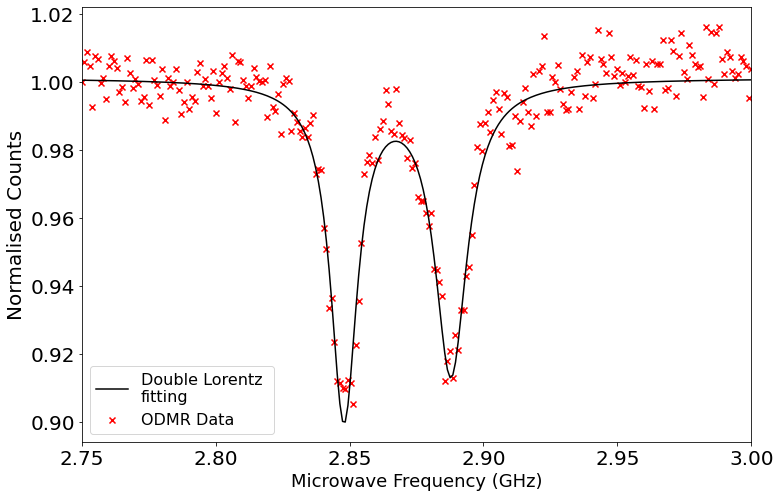

In [109]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\20201125\\Lock_in_adaptive\\'
date = '20201125'
scan = '_NVScan_71'
file_name = date + scan +'_averaged_results_lock_in'

odmr_data = load_data(folder_path + '\\' + file_name + '.dat')
print(odmr_data.shape)

freq = odmr_data.iloc[:,0].to_numpy()
step = np.round(freq[1]-freq[0], 4)
mean_odmr_data = odmr_data.iloc[:,1].to_numpy()
# Create the freqeuncy scan array. 
#freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# plot a colour map of the ODMR data and set plot format for the program. 
set_plot_params()

norm_mean_odmr = normalise_data(mean_odmr_data) # Normalise the daata to tthe off-resonant signal.

# scatter plot of data
fig2, ax2 = scatter_plot(freq, norm_mean_odmr)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, contrast, flourescent_baseline = get_init_params(mean_odmr_data, freq)

# create the initial parameters for ODMR double lorentzian 
# line fitting
#init_params = [contrast[0], freq_mins[0], 0.001, -90, freq_mins[1], 0.001, flourescent_baseline]
init_params = [contrast[0], 2.85, 0.001, contrast[1], 2.88, 0.001, flourescent_baseline]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq[50:181], mean_odmr_data[50:181], init_params)

# create the double lorentz fit array
y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])

norm_y_fit =  normalise_data(y_fit)

# plot the fitting to ax2
ax2 = plot_fitting(ax2, freq, norm_y_fit, dwell_time)
    
# get the r^2 value for the fitting 
r_squared = get_r_squared(freq, norm_mean_odmr, norm_y_fit)
print(r_squared)

rms_error = get_RMS_error(norm_mean_odmr, norm_y_fit) # RMS value then normalised to the mean of the y_fit array.
print(rms_error)

# Calculate the ODMR contrast from the fitting. 
fitted_contrast = get_fitting_contrast(fitting_params[1], fitting_params[4], freq, y_fit,  fitting_params[6], step)
print(fitted_contrast)

save_data(date, file_name, fitted_contrast, fitting_params, 
    error_in_fit, r_squared, rms_error, fig2)

In [66]:
print(freq_mins)

[2.8483935742971886, 2.886546184738956]
